Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest

In [2]:
# Read New York City property sales data
df = pd.read_csv('https://raw.githubusercontent.com/SeanAntosiak/DS-Unit-2-Regression-Classification/master/data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    
    .astype(int)
)

In [3]:
# gets rid of sales where the sale price was outside of the desired range

df = df[(df['SALE_PRICE']>=100) & (df['SALE_PRICE']<=2000000)]

In [4]:
# gets rid of buildings not classified as one family dwellings
# removes the column for building class category since it is all the same now

df = df[(df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS') & (df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS')]
df.drop(columns=['BUILDING_CLASS_CATEGORY'], inplace=True)

In [5]:
# converts sales date to date time

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [6]:
# checks columns in the dataframe

df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

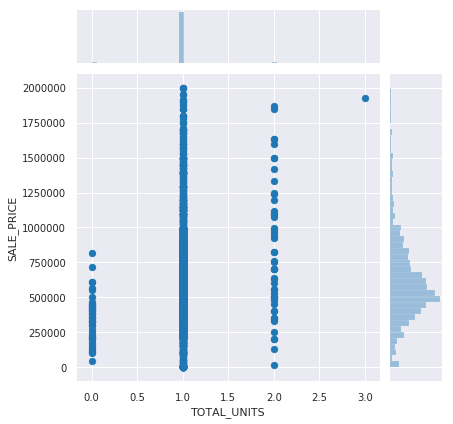

In [7]:
sns.set_style('darkgrid')
sns.jointplot(x=df['TOTAL_UNITS'], y=df['SALE_PRICE']);

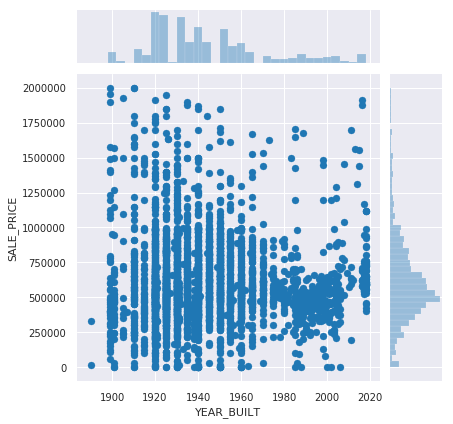

In [8]:
sns.set_style('darkgrid')
sns.jointplot(x=df['YEAR_BUILT'], y=df['SALE_PRICE']);

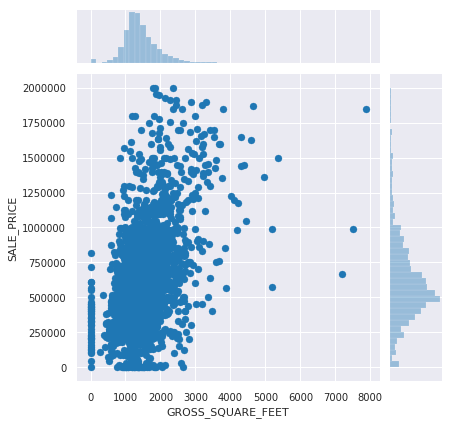

In [9]:
sns.set_style('darkgrid')
sns.jointplot(x=df['GROSS_SQUARE_FEET'], y=df['SALE_PRICE']);

In [10]:
df.head()

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [11]:
# checking to see how many unique variables are in the column

df['APARTMENT_NUMBER'].unique()

array([nan, 'RP.'], dtype=object)

In [12]:
# checking how many occurances of 'RP.' there is 

df['APARTMENT_NUMBER'].value_counts()

RP.    1
Name: APARTMENT_NUMBER, dtype: int64

In [13]:
# checking how many occurances of 'RP.' there is 

df[df['APARTMENT_NUMBER']=='RP.']

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
5351,5,MIDLAND BEACH,1,3809,32,NaN,A5,"143 BADEN PLACE, RP.",RP.,10306.0,1.0,0.0,1.0,800,1000.0,1989.0,1,A5,248000,2019-01-28


In [14]:
# checking to see how many unique variables are in the column

df['TAX_CLASS_AT_TIME_OF_SALE'].unique()

array([1])

In [15]:
# checking to see how many unique variables are in the column


df['EASE-MENT'].unique()

array([nan])

In [16]:
#checking how many total unique values for ADDRESS

df['ADDRESS'].unique().shape

(3211,)

In [17]:
# comparing the unique values in ADDRESS to the total rows in the data frame

df.shape

(3233, 20)

In [18]:
# all of these columns have little varience 
# or are almost unique to their row
# I will remove each of them from the data frame

# I also removed tax class/building class at present because present value
# should not effect what the sale price was in the past

df.drop(columns=['ADDRESS', 'EASE-MENT', 'TAX_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT'], inplace=True)

In [19]:
df.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,5495,801,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,7918,72,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,4210,19,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,5212,69,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,7930,121,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,A5,620000,2019-01-02


In [20]:
# changes BOROUGH and zip code to str to represent catagorical data

df['BOROUGH'] = df['BOROUGH'].astype(str)
df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)

In [21]:
top20Neigh = df['NEIGHBORHOOD'].value_counts()[:20].index
top10Zip = df['ZIP_CODE'].value_counts()[:10].index

df.loc[~df['NEIGHBORHOOD'].isin(top20Neigh), 'NEIGHBORHOOD'] = 'OTHER'
df.loc[~df['ZIP_CODE'].isin(top10Zip), 'ZIP_CODE'] = 'OTHER'

In [22]:
# splits training and test data by dates requested

train = df[(df['SALE_DATE']>='2019-01') & (df['SALE_DATE']<='2019-03-31')].reset_index()
test = df[(df['SALE_DATE']>='2019-4-01') & (df['SALE_DATE']<='2019-04-30')].reset_index()

In [31]:
# used to ignore warnings in next box

import warnings; warnings.simplefilter('ignore')

In [32]:
feats = ['BOROUGH', 'NEIGHBORHOOD', 'ZIP_CODE', 'BUILDING_CLASS_AT_TIME_OF_SALE']
targ = 'SALE_PRICE'

xTrain = train[feats]
yTrain = train[targ]

xTest = test[feats]
yTest = test[targ]

encoder2 = ce.OneHotEncoder(use_cat_names=True)
xTrainEnc = encoder2.fit_transform(xTrain)
xTestEnc = encoder2.transform(xTest)

scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(xTrainEnc)
xTestScaled = scaler.transform(xTestEnc)

for k in range(1,50):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    xTrainSel = selector.fit_transform(xTrainScaled, yTrain)
    xTestSel = selector.transform(xTestScaled)
    
    mod = LR()
    mod.fit(xTrainSel, yTrain)
    
    yPred = mod.predict(xTestSel)
    mae = mean_absolute_error(yTest, yPred)
    print(f'Test MAE: ${mae:,.0f}')              # ask for explination of this line

1 features
Test MAE: $213,316
2 features
Test MAE: $214,294
3 features
Test MAE: $209,543
4 features
Test MAE: $207,108
5 features
Test MAE: $206,599
6 features
Test MAE: $201,339
7 features
Test MAE: $196,088
8 features
Test MAE: $191,300
9 features
Test MAE: $191,479
10 features
Test MAE: $194,068
11 features
Test MAE: $193,494
12 features
Test MAE: $192,639
13 features
Test MAE: $193,518
14 features
Test MAE: $193,519
15 features
Test MAE: $191,222
16 features
Test MAE: $191,473
17 features
Test MAE: $191,598
18 features
Test MAE: $191,559
19 features
Test MAE: $191,140
20 features
Test MAE: $191,358
21 features
Test MAE: $191,357
22 features
Test MAE: $188,364
23 features
Test MAE: $187,866
24 features
Test MAE: $189,182
25 features
Test MAE: $189,236
26 features
Test MAE: $188,554
27 features
Test MAE: $188,334
28 features
Test MAE: $188,633
29 features
Test MAE: $188,094
30 features
Test MAE: $188,101
31 features
Test MAE: $187,421
32 features
Test MAE: $187,314
33 features
Test 

## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.